In [1]:
import openmc_fusion_benchmarks as ofb
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# read sinbad data
experiment_file = ofb.ResultsFromDatabase('experiment.h5', path='results_database')
mcnp_jendl33_file = ofb.ResultsFromDatabase('mcnp-4b-c_jendl33.h5', path='results_database')
mcnp_fendl2_file = ofb.ResultsFromDatabase('mcnp-4b-c_fendl2.h5', path='results_database')

In [3]:
# read openmc results in results_database/
openmc_fendl3_file = ofb.ResultsFromDatabase('openmc-0-14-0_fendl32b.h5', path='results_database')
openmc_endfb8_file = ofb.ResultsFromDatabase('openmc-0-14-0_endfb80.h5', path='results_database')

In [4]:
# initialize reaction rate plots
foil_list = ['nb93', 'in115', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{115}$In(n,n\')$^{115m}$In', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

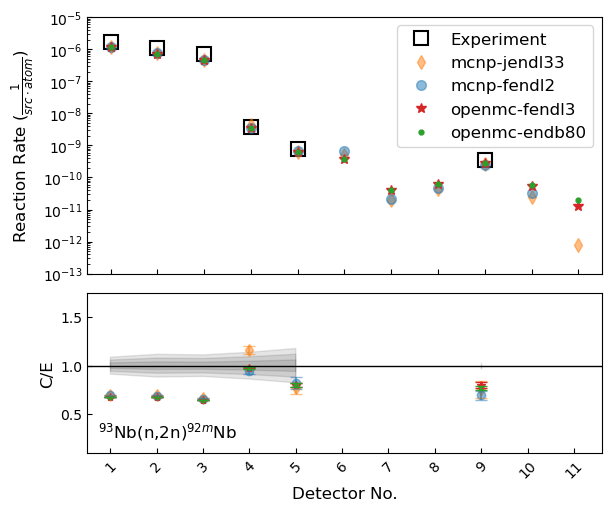

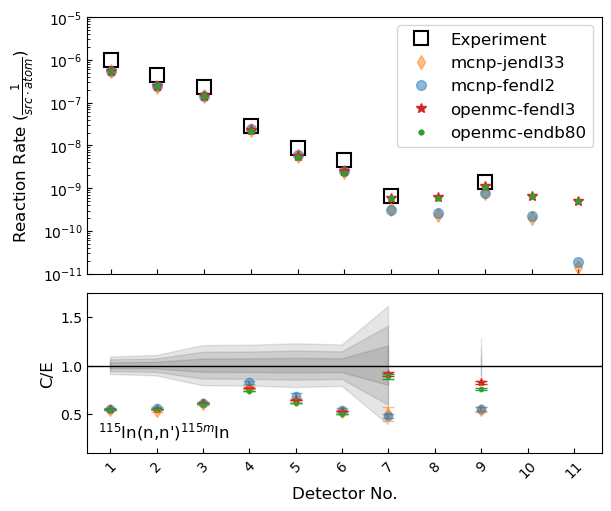

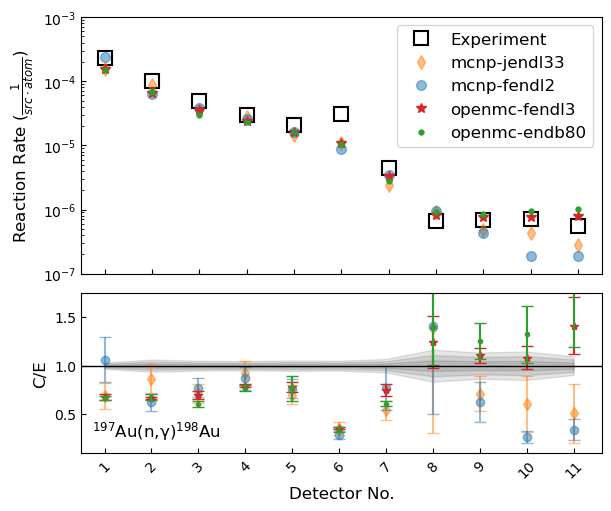

In [5]:
for i,foil in enumerate(foil_list):

    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'rr_{foil}')
    mcnp_jendl33 = mcnp_jendl33_file.get_tally_dataframe(f'rr_{foil}')
    mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'rr_{foil}')
    
    # openmc from results_database/
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'rr_{foil}')
    openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'rr_{foil}')
    
    # plot
    # preprocessing
    dtype_label = reaction_labels[i]
    tickers = np.arange(len(measured))
    xaxis = experiment_file.get_tally_xaxis(f'rr_{foil}')
    means = [measured['mean'], mcnp_jendl33['mean'], mcnp_fendl2['mean']]

    # generate figure
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

    # plot results
    ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
    ax1.plot(tickers, mcnp_jendl33['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=.5, label='mcnp-jendl33')
    ax1.plot(tickers, mcnp_fendl2['mean'], marker='o', ms=7, ls='none', color='tab:blue', alpha=.5, label='mcnp-fendl2')

    # openmc results
    ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', label='openmc-fendl3')
    ax1.plot(tickers, openmc_endfb8['mean'], marker='.', ms=7, ls='none', color='tab:green', label='openmc-endb80')

    ofb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
    ax2.errorbar(tickers, mcnp_jendl33['mean']/measured['mean'], mcnp_jendl33['std. dev.']/measured['mean'], 
                marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=.5, label='_label')
    ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
                marker='o', ms=6, capsize=4, barsabove=True, color='tab:blue', ls='none', alpha=.5, label='_label')
    
    # openmc results
    ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
                marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', label='_label')
    ax2.errorbar(tickers, openmc_endfb8['mean']/measured['mean'], openmc_endfb8['std. dev.']/measured['mean'], 
                marker='.', ms=6, capsize=4, barsabove=True, color='tab:green', ls='none', label='_label')

    # adjust
    ofb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
    ax1.set_yscale('log')
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.set_xticks(tickers)
    ax1.tick_params(axis='x', labelbottom=False)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.legend(fontsize=12)
    #
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
                linewidth=1, label='_nolegend_')
    ax2.set_xlim([-0.5, tickers[-1] + .6])
    ax2.set_ylim([0.1, 1.75])
    ax2.set_xticks(tickers)
    ax2.set_xticklabels(measured[xaxis])
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.tick_params(axis='both', which='both', direction='in')
    ax2.set_xlabel(xaxis, fontsize=12)
    ax2.set_ylabel('C/E', fontsize=12)
    ax2.annotate(dtype_label, [0.02, 0.07], xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='bottom', fontsize=12)

In [6]:
# initialize spectra data
detector_list = ['detector3', 'detector5', 'detector7', 'detector9']
detector_labels = ['detector 3', 'detector 5', 'detector 7', 'detector 9']
ylabel = r'Flux $(\frac{n}{cm^2 \cdot src \cdot lethargy})$'

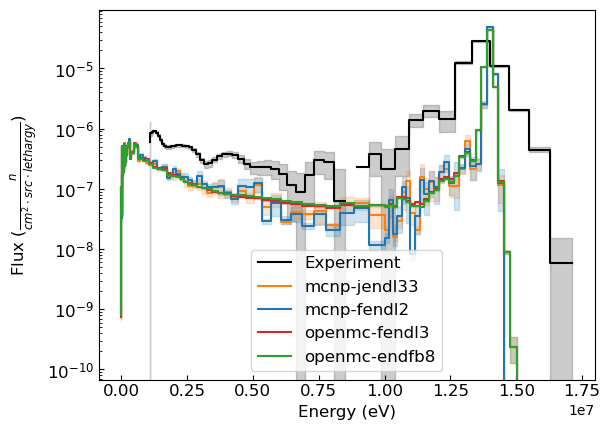

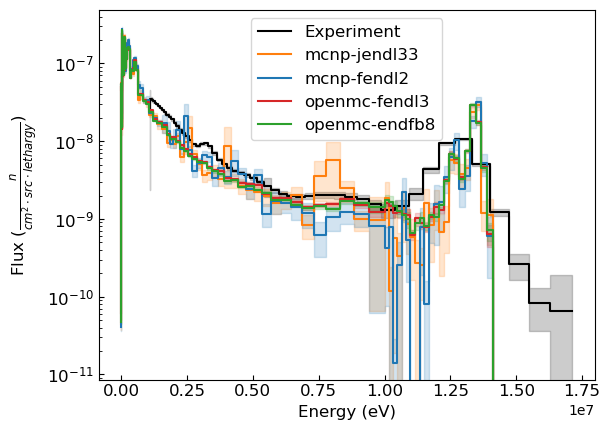

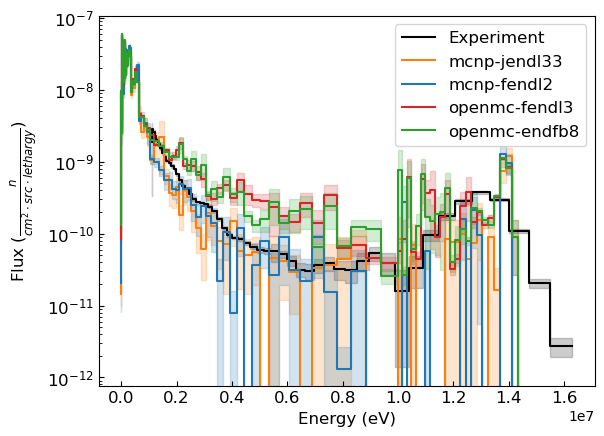

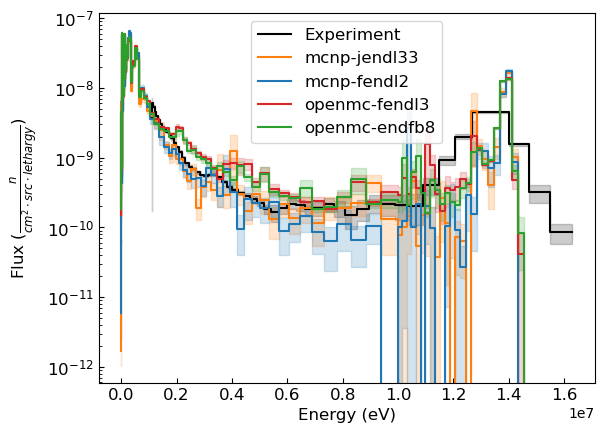

In [7]:
for i, dl in enumerate(detector_list):
    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'nspectrum_{dl}')
    mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'nspectrum_{dl}')
    mcnp_jendl33 = mcnp_jendl33_file.get_tally_dataframe(f'nspectrum_{dl}')
    
    # openmc from results_database/
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'nspectrum_{dl}')
    openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'nspectrum_{dl}')

    # plot
    # preprocessing
    measured_mean = measured['mean'] / np.log(measured['energy high [eV]']/measured['energy low [eV]'])
    measured_stddev = measured['std. dev.'] / np.log(measured['energy high [eV]']/measured['energy low [eV]'])
    mcnp_fendl2_mean = mcnp_fendl2['mean'] / np.log(mcnp_fendl2['energy high [eV]']/mcnp_fendl2['energy low [eV]'])
    mcnp_fendl2_stddev = mcnp_fendl2['std. dev.'] / np.log(mcnp_fendl2['energy high [eV]']/mcnp_fendl2['energy low [eV]'])
    mcnp_jendl33_mean = mcnp_jendl33['mean'] / np.log(mcnp_jendl33['energy high [eV]']/mcnp_jendl33['energy low [eV]'])
    mcnp_jendl33_stddev = mcnp_jendl33['std. dev.'] / np.log(mcnp_jendl33['energy high [eV]']/mcnp_jendl33['energy low [eV]'])

    openmc_fendl3_mean = openmc_fendl3['mean'] / np.log(openmc_fendl3['energy high [eV]']/openmc_fendl3['energy low [eV]'])
    openmc_fendl3_stddev = openmc_fendl3['std. dev.'] / np.log(openmc_fendl3['energy high [eV]']/openmc_fendl3['energy low [eV]'])
    openmc_endfb8_mean = openmc_endfb8['mean'] / np.log(openmc_endfb8['energy high [eV]']/openmc_endfb8['energy low [eV]'])
    openmc_endfb8_stddev = openmc_endfb8['std. dev.'] / np.log(openmc_endfb8['energy high [eV]']/openmc_endfb8['energy low [eV]'])
    
    # generate figure
    fig, ax = plt.subplots()

    # plot results
    ax.step(measured['energy low [eV]'], measured_mean, lw=1.5, c='k', label='Experiment')
    ax.fill_between(measured['energy low [eV]'], measured_mean - measured_stddev, measured_mean +
                            measured_stddev, step='pre', color='k', alpha=0.2)
    ax.step(mcnp_jendl33['energy low [eV]'], mcnp_jendl33_mean, lw=1.5, c='tab:orange', label='mcnp-jendl33')
    ax.fill_between(mcnp_jendl33['energy low [eV]'], mcnp_jendl33_mean - mcnp_jendl33_stddev, mcnp_jendl33_mean +
                            mcnp_jendl33_stddev, step='pre', color='tab:orange', alpha=0.2)
    ax.step(mcnp_fendl2['energy low [eV]'], mcnp_fendl2_mean, lw=1.5, c='tab:blue', label='mcnp-fendl2')
    ax.fill_between(mcnp_fendl2['energy low [eV]'], mcnp_fendl2_mean - mcnp_fendl2_stddev, mcnp_fendl2_mean +
                            mcnp_fendl2_stddev, step='pre', color='tab:blue', alpha=0.2)
    
    # openmc results
    ax.step(openmc_fendl3['energy low [eV]'], openmc_fendl3_mean, lw=1.5, c='tab:red', label='openmc-fendl3')
    ax.fill_between(openmc_fendl3['energy low [eV]'], openmc_fendl3_mean - openmc_fendl3_stddev, openmc_fendl3_mean +
                            openmc_fendl3_stddev, step='pre', color='tab:red', alpha=0.2)
    ax.step(openmc_endfb8['energy low [eV]'], openmc_endfb8_mean, lw=1.5, c='tab:green', label='openmc-endfb8')
    ax.fill_between(openmc_endfb8['energy low [eV]'], openmc_endfb8_mean - openmc_endfb8_stddev, openmc_endfb8_mean +
                            openmc_endfb8_stddev, step='pre', color='tab:green', alpha=0.2)

    # adjust
    ax.set_yscale('log')
    ax.set_xlabel('Energy (eV)', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
    ax.legend(fontsize=12)
